In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from utils import roar_data_path as project_data_path
from utils import roar_code_path as project_code_path
from utils import city_list
import gev_city_utils as gevcu
import single_loc_eval as sle
import plotting_utils as pu

In [2]:
# Set fonts
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

### Map checks

In [3]:
# # Test
# ensemble = 'LOCA2'
# gcm = 'ACCESS-CM2'
# ssp = 'ssp245'
# member = 'r1i1p1f1'

# ds_fit = xr.open_dataset('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/extreme_value/original_grid/max_pr/LOCA2_ACCESS-CM2_r1i1p1f1_ssp370_1950-2100_nonstat_scale_mle_nboot100.nc')
# ds_data = xr.open_mfdataset('/storage/group/pches/default/users/dcl5300/conus_comparison_lafferty-etal-2024/metrics/LOCA2/max_pr_ACCESS-CM2_r1i1p1f1_ssp370_*.nc')

### Single location example

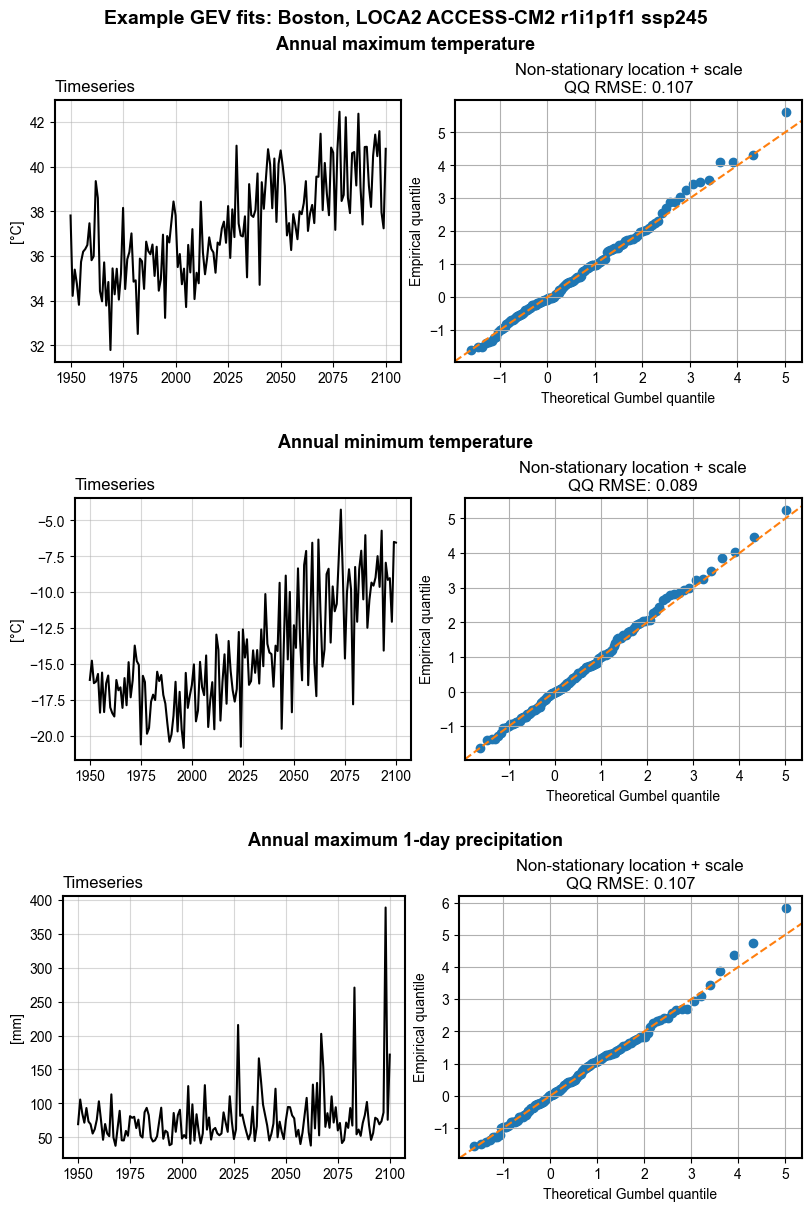

In [4]:
def plot_gev_row(fig, subfig, city, metric_id, ensemble, gcm, ssp, member):
    """Plot QQ plots for a single metric across non-stat loc and loc+scale models."""
    axs = subfig.subplots(1, 2)

    # Read both
    df_obs = pd.read_csv(f'{project_data_path}/metrics/cities/{city}_{metric_id}.csv')
    
    # Left: timeseries
    ax = axs[0]
    df_obs_plot = df_obs[(df_obs['gcm'] == gcm) & (df_obs['ssp'].isin([ssp, 'historical'])) & (df_obs['member'] == member) & (df_obs['ensemble'] == ensemble)]
    ax.plot(df_obs_plot['time'], df_obs_plot[metric_id.split('_')[1]], color='black')
    ax.grid(alpha=0.5)
    ax.set_ylabel(pu.gev_labels[metric_id])
    ax.set_title('Timeseries', loc='left')
    
    # Middle: Non-stationary location only
    # df_fit_nsl = pd.read_csv(
    #     f'{project_data_path}/extreme_value/cities/original_grid/freq/'
    #     f'{city}_{metric_id}_1950-2100_mle_nonstat_nboot100_samples.csv'
    # )
    # stats_nsl = sle.gev_qq_plot(
    #     df_fit=df_fit_nsl, df_obs=df_obs, metric_id=metric_id,
    #     gcm=gcm, ssp=ssp, member=member, ensemble=ensemble,
    #     gev_type='nonstat', ax=axs[1]
    # )
    # axs[1].set_title(
    #     f"Non-stationary location only\nQQ RMSE: {stats_nsl[0]:.3f}, "
    #     f"AIC: {stats_nsl[2]:.2f}, BIC: {stats_nsl[3]:.2f}", loc='left'
    # )
    
    # Right: Non-stationary location + scale
    df_fit_nsls = pd.read_csv(
        f'{project_data_path}/extreme_value/cities/original_grid/freq/'
        f'{city}_{metric_id}_1950-2100_mle_nonstat_scale_nboot100_samples.csv'
    )
    stats_nsls = sle.gev_qq_plot(
        df_fit=df_fit_nsls, df_obs=df_obs, metric_id=metric_id,
        gcm=gcm, ssp=ssp, member=member, ensemble=ensemble,
        gev_type='nonstat_scale', ax=axs[-1]
    )
    axs[-1].set_title(
        f"Non-stationary location + scale\nQQ RMSE: {stats_nsls[0]:.3f}"
        # f"AIC: {stats_nsls[2]:.2f}, BIC: {stats_nsls[3]:.2f}", loc='left'
    )
    
    return axs


# Config
city = 'boston'
ensemble = 'LOCA2'
gcm = 'ACCESS-CM2'
ssp = 'ssp245'
member = 'r1i1p1f1'

metric_ids = ['max_tasmax', 'min_tasmin', 'max_pr']

fig = plt.figure(figsize=(8, 12), layout='constrained')
subfigs = fig.subfigures(3, 1, hspace=0.05)

fig.suptitle(f"Example GEV fits: {city.capitalize()}, {ensemble} {gcm} {member} {ssp}", fontweight='bold', fontsize=14)

for subfig, metric_id in zip(subfigs, metric_ids):
    subfig.suptitle(pu.title_labels[metric_id], fontsize=13, fontweight='bold')
    plot_gev_row(fig, subfig, city, metric_id, ensemble, gcm, ssp, member)

plt.savefig(f"{project_code_path}/figs/si/{city}_example_gev_fits.pdf")

### All cities

In [79]:
%%time
# Calculate all
df_stats = []
# gev_types = ['stat', 'nonstat_scale']
gev_types = ['nonstat_scale']

# Metrics
for metric_id in ["max_tasmax", "min_tasmin", "max_pr"]:
    # Cities
    for city in city_list:
        # Read obs
        df_obs = pd.read_csv(f'{project_data_path}/metrics/cities/{city}_{metric_id}.csv')

        # Loop through GEV types
        for gev_type in gev_types:
            # Read fit
            if gev_type == 'stat':
                df_fit = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2014_2050-2100_lmom_stat_nbootproj1000_nboothist1_samples.csv')            
            elif gev_type == 'nonstat':
                df_fit = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2100_mle_nonstat_nboot100_samples.csv')
            elif gev_type == 'nonstat_scale':
                df_fit = pd.read_csv(f'{project_data_path}/extreme_value/cities/original_grid/freq/{city}_{metric_id}_1950-2100_mle_nonstat_scale_nboot100_samples.csv')
            
            # Loop through meta-ensemble members
            combos = df_fit.set_index(["ensemble", "gcm", "member", "ssp"]).sort_index().index.unique()
            for combo in combos:
                ensemble, gcm, member, ssp = combo
                # Calculate stats
                try:
                    stats = sle.gev_qq_plot(
                        df_fit=df_fit,
                        df_obs=df_obs,
                        metric_id=metric_id,
                        gcm=gcm,
                        ssp=ssp,
                        member=member,
                        ensemble=ensemble,
                        gev_type=gev_type,
                        )
                    # Append
                    qq_rmse, log_lik, aic, bic = stats
                    df_stats.append({"city":city,
                                    "metric_id":metric_id,
                                    "ensemble":ensemble,
                                    "gcm":gcm,
                                    "member":member,
                                    "ssp":ssp,
                                    "gev_type":gev_type,
                                    "qq_rmse":qq_rmse,
                                    "log_lik":log_lik,
                                    "aic":aic,
                                    "bic":bic,
                                   })
                except Exception as e:
                    print(combo)
                    continue

# Concat
df_stats = pd.DataFrame(df_stats).dropna()

CPU times: user 8min 20s, sys: 1.3 s, total: 8min 21s
Wall time: 8min 34s


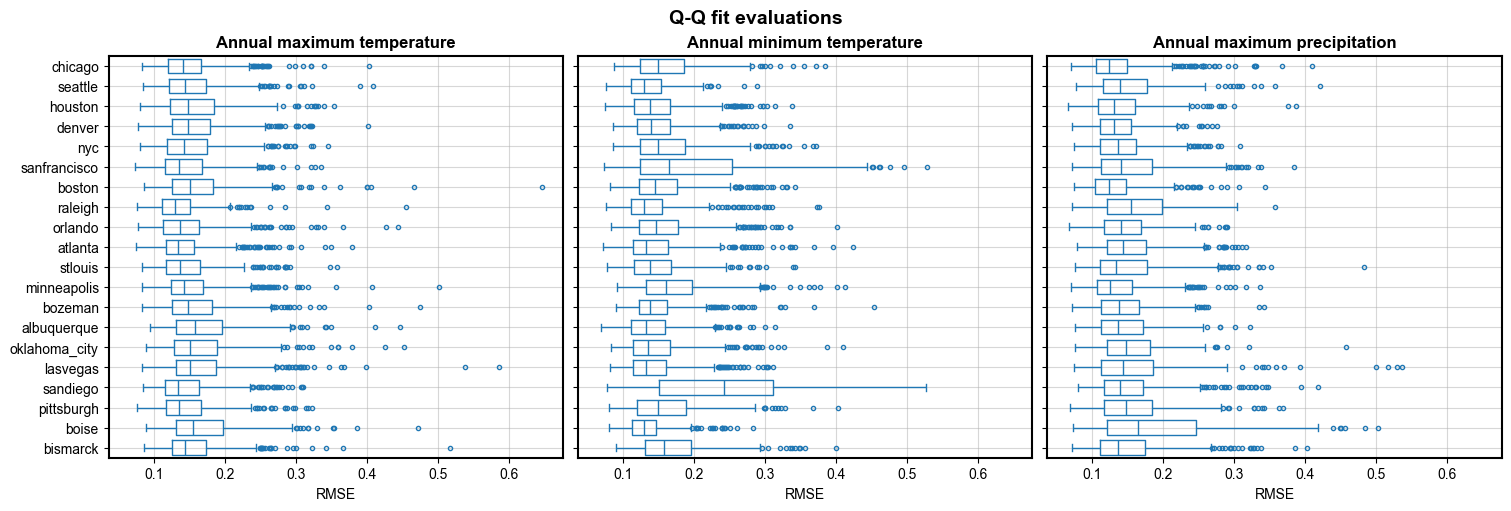

In [82]:
# Plot all
fig, axs = plt.subplots(1, 3, layout='constrained', figsize=(15, 5), sharey=True, sharex=True)

# Max tasmax
data = df_stats[df_stats['metric_id'] == 'max_tasmax']
sns.boxplot(data=data, y='city', x='qq_rmse', ax=axs[0], fill=False, gap=.1, linewidth=1, flierprops={"marker": "."}, legend=False)
axs[0].set_title("Annual maximum temperature", fontweight='bold')

# Min tasmin
data = df_stats[df_stats['metric_id'] == 'min_tasmin']
sns.boxplot(data=data, y='city', x='qq_rmse', ax=axs[1], fill=False, gap=.1, linewidth=1, flierprops={"marker": "."}, legend=False)
axs[1].set_title("Annual minimum temperature", fontweight='bold')

# Max pr
data = df_stats[df_stats['metric_id'] == 'max_pr']
sns.boxplot(data=data, y='city', x='qq_rmse', ax=axs[2], fill=False, gap=.1, linewidth=1, flierprops={"marker": "."}, legend=False)
axs[2].set_title("Annual maximum precipitation", fontweight='bold')

# Tidy
for ax in axs:
    ax.grid(alpha=0.5)
    ax.set_xlabel('RMSE')
    ax.set_ylabel('')
fig.suptitle('Q-Q fit evaluations', fontweight='bold', fontsize=14)

plt.savefig(f'{project_code_path}/figs/si/city_nonstat_gev_evals.pdf', bbox_inches='tight')

In [65]:
# # May want to add this for stationary comparison
# def plot_all(axs, data):
#     sns.boxplot(data=data[(data['gev_type'] == 'nonstat_scale')], y='city', x='qq_rmse', ax=axs[0], fill=False, gap=.1, linewidth=1, flierprops={"marker": "."}, legend=False)
#     axs[0].set_title('Non-stationary GEV (1950-2100)')

#     sns.boxplot(data=data[(data['gev_type'] == 'stat') & (data['ssp'] == 'historical')], y='city', x='qq_rmse', ax=axs[1], fill=False, gap=.1, linewidth=1, flierprops={"marker": "."}, legend=False)
#     axs[1].set_title('Stationary GEV (historical; 1950-2014)')
    
#     sns.boxplot(data=data[(data['gev_type'] == 'stat') & (data['ssp'] != 'historical')], y='city', x='qq_rmse', ax=axs[2], fill=False, gap=.1, linewidth=1, flierprops={"marker": "."}, legend=False)
#     axs[2].set_title('Stationary GEV (projection; 2050-2100)')
    
#     for ax in axs:
#         ax.grid(alpha=0.5)
#         ax.set_xlabel('')
#         ax.set_ylabel('')

# # Plot all
# fig = plt.figure(layout='constrained', figsize=(15, 18))
# subfigs = fig.subfigures(3, 1, wspace=0.07)

# # Max tasmax
# axs = subfigs[0].subplots(1, 3, sharey=True)
# data = df_stats[df_stats['metric_id'] == 'max_tasmax']
# plot_all(axs, data)
# subfigs[0].suptitle("Annual maximum temperature", fontweight='bold')

# # Min tasmin
# axs = subfigs[1].subplots(1, 3, sharey=True)
# data = df_stats[df_stats['metric_id'] == 'min_tasmin']
# plot_all(axs, data)
# subfigs[2].suptitle("Annual minimum temperature", fontweight='bold')

# # Max pr
# axs = subfigs[2].subplots(1, 3, sharey=True)
# data = df_stats[df_stats['metric_id'] == 'max_pr']
# plot_all(axs, data)
# subfigs[2].suptitle("Annual maximum precipitation", fontweight='bold')

# # plt.savefig(f'{project_code_path}/figs/si_city_nonstat_gev_evals.pdf', bbox_inches='tight')
# plt.show()

In [14]:
################
####  OLD   ####
################

In [13]:
# # Merge to get differences 
# df_stats_merged = pd.merge(
#     df_stats[df_stats["gev_type"] == "nonstat"],
#     df_stats[df_stats["gev_type"] == "nonstat_scale"],
#     how='inner', on=['gcm', 'ssp', 'ensemble', 'member', 'city', 'metric_id'],
#     suffixes = ('_loc', '_loc-scale'))

# df_stats_merged['rmse_diff'] = df_stats_merged['qq_rmse_loc'] - df_stats_merged['qq_rmse_loc-scale']
# df_stats_merged['aic_diff'] = df_stats_merged['aic_loc'] - df_stats_merged['aic_loc-scale']
# df_stats_merged['bic_diff'] = df_stats_merged['bic_loc'] - df_stats_merged['bic_loc-scale']

# # Store fractions preferring location + scale model
# df_stats_merged.groupby(['city', 'metric_id']).apply(lambda x: (x[['aic_diff']] < 0).mean(), include_groups=False).to_csv(f'{project_code_path}/data/city_aic_diff_frac_below_zero.csv')
# df_stats_merged.groupby(['city', 'metric_id']).apply(lambda x: (x[['bic_diff']] < 0).mean(), include_groups=False).to_csv(f'{project_code_path}/data/city_bic_diff_frac_below_zero.csv')

In [12]:
# def plot_all(axs, data, data_merged):
#     sns.boxplot(data=data, y='city', x='qq_rmse', hue='gev_type', ax=axs[0], fill=False, gap=.1, linewidth=1, flierprops={"marker": "."}, legend=False)
#     axs[0].set_title('Q-Q RMSE')
#     sns.boxplot(data=data, y='city', x='aic', hue='gev_type', ax=axs[2], fill=False, gap=.1, linewidth=1, flierprops={"marker": "."}, legend=False)
#     axs[2].set_title('AIC')
#     sns.boxplot(data=data, y='city', x='bic', hue='gev_type', ax=axs[4], fill=False, gap=.1, linewidth=1, flierprops={"marker": "."}, legend=False)
#     axs[4].set_title('BIC')

#     sns.boxplot(data=data_merged, y='city', x='rmse_diff', ax=axs[1], fill=False, gap=.1, linewidth=1, flierprops={"marker": ".", "color":"black"}, linecolor='black', color="black")
#     axs[1].set_title('Q-Q RMSE difference')
#     sns.boxplot(data=data_merged, y='city', x='aic_diff', ax=axs[3], fill=False, gap=.1, linewidth=1, flierprops={"marker": ".", "color":"black"}, linecolor='black', color="black")
#     axs[3].set_title('AIC difference')
#     axs[3].set_xlim([-10,30])
#     sns.boxplot(data=data_merged, y='city', x='bic_diff', ax=axs[5], fill=False, gap=.1, linewidth=1, flierprops={"marker": ".", "color":"black"}, linecolor='black', color="black")
#     axs[5].set_title('BIC difference')
#     axs[5].set_xlim([-10,30])

#     for ax in axs:
#         ax.grid(alpha=0.5)
#         ax.set_xlabel('')
#         ax.set_ylabel('')

# # Plot all
# fig = plt.figure(layout='constrained', figsize=(15, 18))
# subfigs = fig.subfigures(4, 1, wspace=0.07, height_ratios = [1,10,10,10])

# # Legend
# ax = subfigs[0].subplots()
# legend_elements = [Line2D([0], [0], color='C0', lw=3, label='Non-stationary location only'),
#                    Line2D([0], [0], color='C1', lw=3, label='Non-stationary location + scale'),
#                    Line2D([0], [0], color='black', lw=3, label='Difference (positive prefers non-stationary location only model)')]
# ax.legend(handles=legend_elements, loc='center', ncols=3)
# ax.axis('off')

# # Max tasmax
# axs = subfigs[1].subplots(1, 6, sharey=True)
# data = df_stats[df_stats['metric_id'] == 'max_tasmax']
# data_merged = df_stats_merged[df_stats_merged['metric_id'] == 'max_tasmax']
# plot_all(axs, data, data_merged)
# subfigs[1].suptitle("Annual maximum temperature", fontweight='bold')

# # Min tasmin
# axs = subfigs[2].subplots(1, 6, sharey=True)
# data = df_stats[df_stats['metric_id'] == 'min_tasmin']
# data_merged = df_stats_merged[df_stats_merged['metric_id'] == 'min_tasmin']
# plot_all(axs, data, data_merged)
# subfigs[2].suptitle("Annual minimum temperature", fontweight='bold')

# # Max pr
# axs = subfigs[3].subplots(1, 6, sharey=True)
# data = df_stats[df_stats['metric_id'] == 'max_pr']
# data_merged = df_stats_merged[df_stats_merged['metric_id'] == 'max_pr']
# plot_all(axs, data, data_merged)
# subfigs[3].suptitle("Annual maximum precipitation", fontweight='bold')

# plt.savefig(f'{project_code_path}/figs/si_city_nonstat_gev_comparison.pdf', bbox_inches='tight')